# Problem 2

### a.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import njit

##### Initialization of functions and parameters

In [26]:
#Params
#k = 1.380649e-23
T = 300
#beta = 1/k
beta = 1
k = 1
n_steps = 200
n_sim = 100 

#Binding sites
binding_sites = np.zeros(501)

center = len(binding_sites)//2
half_span = 50 #101 particles = 2*50 + 1

binding_sites[center - half_span : center + half_span + 1] = 1

#Potential
@njit
def V1(x):
    return k

@njit
def V2(x):
    return -k*x

#Probabilities
@njit
def p(x0, V ):
    p_minus = 1.0/(1.0 + np.exp(-beta*(V(x0 + 1) - V(x0 - 1))) + np.exp(-beta*(V(x0) - V(x0 - 1))))
    p_neutral = 1.0/(1.0 + np.exp(-beta*(V(x0 - 1) - V(x0))) + np.exp(-beta*(V(x0 + 1) - V(x0))))
    p_plus = 1.0/(1.0 + np.exp(-beta*(V(x0 - 1) - V(x0 + 1))) + np.exp(-beta*(V(x0) - V(x0 + 1))))
    
    return np.array([p_minus, p_neutral, p_plus])


In [27]:
#Walk simulation
@njit
def random_walk(initial_grid, V, n_steps):
    grid = initial_grid.copy()
    n_sites = len(grid)
    
    for _ in range(n_steps):
        grid_new = np.zeros(n_sites)
        
        for i in range(n_sites):
            
            n_particles = int(grid[i])
            
            if n_particles == 0:
                continue
            
            for _ in range(n_particles):
                p_minus, p_neutral, p_plus = p(i, V)
                r = np.random.uniform(0.0, 1.0)
                
                if r < p_minus:
                    grid_new[i - 1] += 1
                elif r > 1 - p_plus:
                    grid_new[i + 1] += 1
                else:
                    grid_new[i] += 1
                    
        grid = grid_new
        
    return grid

#Several simulations and step
def sim_walk(initial_grid, V, n_steps, n_sim):
    n_sites = len(initial_grid)
    
    grids = np.zeros((n_sim, n_sites))
    
    for i in range(n_sim):
        grid = random_walk(initial_grid, V, n_steps)
        grids[i] = grid

    mean_grid = np.mean(grids, axis = 0)
    x = np.arange(n_sites) - n_sites//2
        
    fig, ax = plt.subplots(figsize = (8, 4))
    
    ax.plot(x, mean_grid)
    ax.set_xlabel("x")
    ax.set_ylabel("Average particle count")
    ax.set_title(f"Average dist of particles after {n_steps} steps and {n_sim} runs")
    plt.show()
    
    return x, mean_grid
    

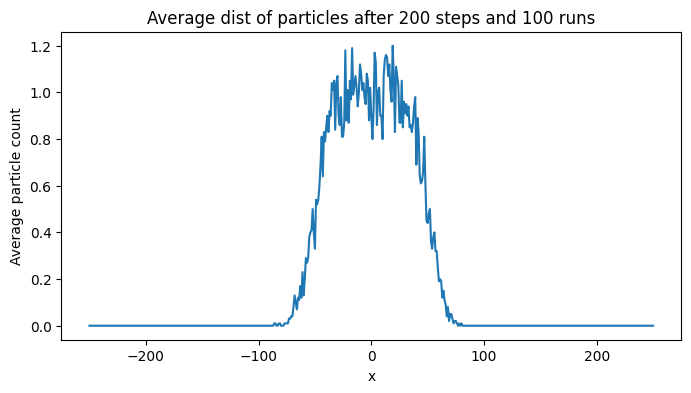

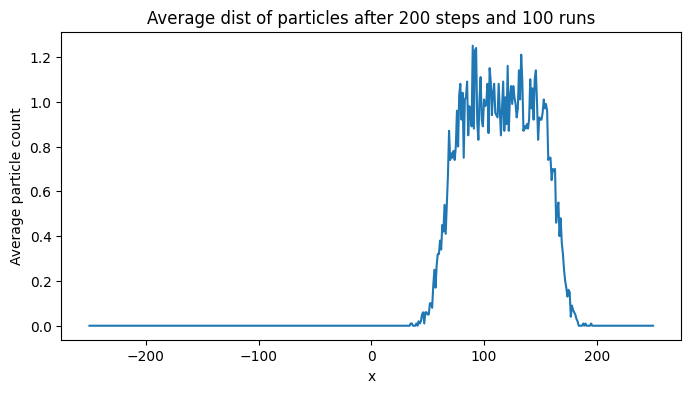

In [28]:
x, mean_grid = sim_walk(binding_sites, V1, n_steps, n_sim)
x, mean_grid = sim_walk(binding_sites, V2, n_steps, n_sim)

### b.

In [29]:
@njit
def random_walk_exclusion(initial_grid, V, n_steps):    
    occupancy = initial_grid.astype(np.bool_) 
    positions = np.where(occupancy)[0].copy() 
    
    for _ in range(n_steps):
        np.random.shuffle(positions)
        
        for idx in range(len(positions)):
            i = positions[idx]
            
            p_minus, p_neutral, p_plus = p(i, V)
            r = np.random.uniform(0.0, 1.0)
                
            if r < p_minus:
                new_i = i-1
            elif r > 1 - p_plus:
                new_i = i + 1
            else:
                new_i = i
        
            if occupancy[new_i]:
                continue
            
            occupancy[i] = False
            occupancy[new_i] = True
            positions[idx] = new_i
            
    return occupancy.astype(np.int64)

def sim_walk_exclusion(initial_grid, V, n_steps, n_sim):
    n_sites = len(initial_grid)
    
    grids = np.zeros((n_sim, n_sites))
    grids_exclusion = np.zeros((n_sim, n_sites))
    
    for i in range(n_sim):
        grid = random_walk(initial_grid, V, n_steps)
        grid_exclusion = random_walk_exclusion(initial_grid, V, n_steps)
        grids[i] = grid
        grids_exclusion[i] = grid_exclusion

    mean_grid = np.mean(grids, axis = 0)
    mean_grid_exclusion = np.mean(grids_exclusion, axis = 0)
    x = np.arange(n_sites) - n_sites//2
        
    fig, ax = plt.subplots(figsize = (8, 4))
    
    ax.plot(x, mean_grid, label = "Non-exclusion")
    ax.plot(x, mean_grid_exclusion, label = "Exclusion")
    ax.set_xlabel("x")
    ax.set_ylabel("Average particle count")
    ax.set_title(f"Average dist of particles after {n_steps} steps and {n_sim} runs")
    plt.legend()
    plt.show()
    
    return x, mean_grid, mean_grid_exclusion


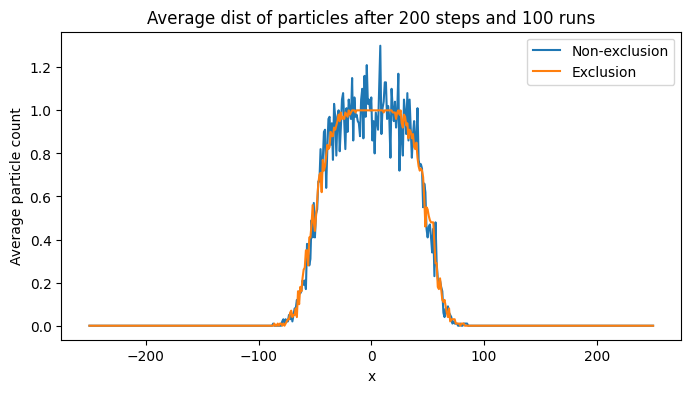

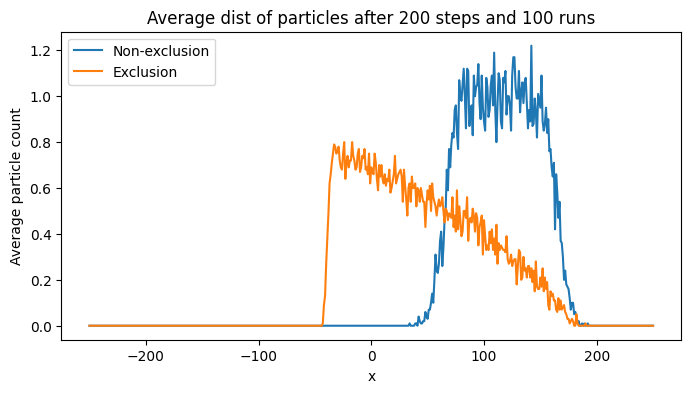

In [30]:
x, mean_grid, mean_grid_exclusion = sim_walk_exclusion(binding_sites, V1, n_steps, n_sim)
x, mean_grid, mean_grid_exclusion = sim_walk_exclusion(binding_sites, V2, n_steps, n_sim)

### c.

Overflow, use instead approx here

# Problem 3

In [31]:
#Params
alpha = 0.8
Tp = 500
h = 1
Nx = 100
dt = 1
#k = 1.380649e-23
#beta = 1000/k
k = 1
beta =1
Np = 12*Nx

#Initial grid
x = np.full(2*Nx, Np//(2*Nx))

#Potentials
@njit
def V1_sawtooth(x, alpha = 0.8, Nx = 100, k = 1.0):
    xPeriodic = x % Nx
    if xPeriodic < alpha * Nx:
        return k*xPeriodic/(alpha*Nx)
    else:
        return k*(Nx - xPeriodic)/(Nx - alpha*Nx)

@njit
def V2_flat(x):
    return 0.0

@njit
def active_potential(t, Tp, V1, V2):
    if (t // Tp) % 2 == 0:
        return V2
    else:
        return V1


#Simulation
@njit
def stepDirection(i, p_minus, p_plus):
    r = np.random.uniform(0 , 1)
    
    if r < p_minus:
        return (i-1)%(2*Nx)
    elif r > 1 - p_plus:
        return (i + 1)%(2*Nx)
    else:
        return i%(2*Nx)

@njit    
def random_walk_sawtooth(x, Tp, h = 1, T = 20*Tp):
    grid = x.copy().astype(np.int64)
    J_arr = np.zeros(T)
    
    for t in range(0, T, h):
        grid_new = np.zeros(len(grid), dtype = np.int64)
        
        nplus = 0
        nminus = 0
        
        for i in range(len(grid)):
            
            n_particles = int(grid[i])
            
            if n_particles == 0:
                continue
            
            for _ in range(n_particles):
                
                if (t // Tp) % 2 == 0:
                    p_minus, p_neutral, p_plus = p(i, V2_flat)
                else:
                    p_minus, p_neutral, p_plus = p(i, V1_sawtooth)
                
                idx = stepDirection(i, p_minus, p_plus)
                
                if idx == (i + 1) % (2*Nx): 
                    nplus += 1
                elif idx == (i - 1) % (2*Nx): 
                    nminus += 1
                
                
                grid_new[idx] += 1
                    
        grid = grid_new
        
        J = (nplus - nminus)/sum(grid)
        J_arr[t] = J
        
    n_cycles = len(J_arr)//(2*Tp)
    #cycle_avg_J = J_arr.reshape(n_cycles, 2*Tp).mean(axis = 1), isnt supported in numba
    J_reshaped = J_arr.reshape(n_cycles, 2*Tp)
    cycle_avg_J = np.zeros(n_cycles)
    
    for c in range(n_cycles):
        cycle_avg_J[c] = J_reshaped[c].mean()
    
    return grid, cycle_avg_J

@njit
def p2(x0, V, beta=beta, L=2*Nx):
    xm = (x0 - 1) % L
    xp = (x0 + 1) % L

    Vm = V(xm)
    V0 = V(x0)
    Vp = V(xp)

    # numerical stability
    ref = min(Vm, V0, Vp)

    wm = np.exp(-beta * (Vm - ref))
    w0 = np.exp(-beta * (V0 - ref))
    wp = np.exp(-beta * (Vp - ref))

    Z = wm + w0 + wp
    return wm/Z, w0/Z, wp/Z   # p_minus, p_neutral, p_plus

@njit
def random_walk_fast(x, Tp, h=1, T=20*Tp):
    grid = x.copy().astype(np.int64)
    L = len(grid)
    Np = grid.sum()

    rng = np.random.default_rng()
    J_arr = np.zeros(T)

    for t in range(0, T, h):
        grid_new = np.zeros(L, dtype=np.int64)

        V = active_potential(t, Tp, V1_sawtooth, V2_flat)  # once per time step

        nplus = 0
        nminus = 0

        for i in range(L):
            n_particles = grid[i]
            if n_particles == 0:
                continue

            p_minus, p_neutral, p_plus = p2(i, V)

            # sample how many go left/stay/right (one call, no particle loop)
            n_m, n_0, n_p = rng.multinomial(n_particles, [p_minus, p_neutral, p_plus])

            grid_new[(i - 1) % L] += n_m
            grid_new[i] += n_0
            grid_new[(i + 1) % L] += n_p

            nminus += n_m
            nplus += n_p

        grid = grid_new
        J_arr[t] = (nplus - nminus) / Np

    n_cycles = len(J_arr) // (2 * Tp)
    cycle_avg_J = J_arr[:n_cycles * (2*Tp)].reshape(n_cycles, 2*Tp).mean(axis=1)

    return grid, cycle_avg_J
    

In [32]:
Tp_arr = np.linspace(1, 1001, 50).astype(np.int64)
J_avg_arr = np.zeros(len(Tp_arr))


for idx, Tp in enumerate(Tp_arr):
    grid0 = np.zeros(2*Nx)
    grid0[0] = Np//2
    grid0[Nx] = Np//2
    
    grid, J_avg = random_walk_sawtooth(grid0, Tp, h = 1, T = 2*Tp)
    J_avg_arr[idx] = J_avg[0]   
    

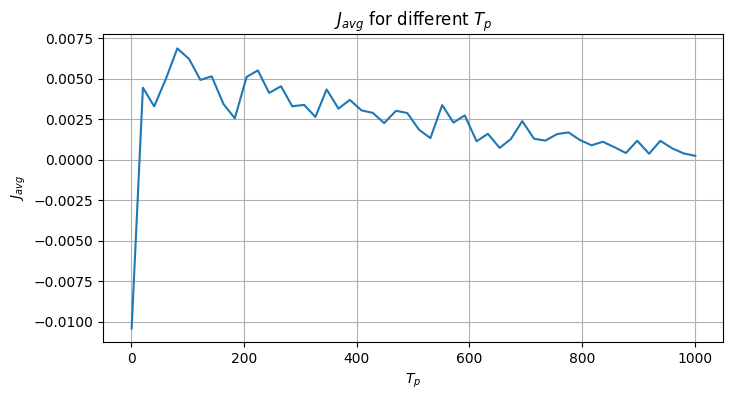

In [33]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(Tp_arr, J_avg_arr)
ax.set_title(r"$J_{avg}$ for different $T_p$")
ax.set_xlabel(r"$T_p$")
ax.set_ylabel(r"$J_{avg}$")
ax.grid()

plt.show()

# Problem 4

### a.

In [34]:
#init params
beta = 1000
k = 1
Nx = 20
Ns = 4
alpha = 0.2
Tp = 40
Np = 20
b = 4 #Should be even
partition = 3

#Initial grid


@njit
def build_initial(width, partition, Nx, Ns, Np = -1):
    binding_sites = np.zeros(Ns*Nx)
    center = len(binding_sites)//2
    initial_grid = binding_sites.copy()
    
    if Np == -1:
        N_possible = len(binding_sites)//width
        Np = N_possible//partition
    
    initial_grid[center] = 1
    half = (Np - 1)//2
    
    for n in range(1, half + 1):
        initial_grid[center - n*width] = 1
        initial_grid[center + n*width] = 1
    
    return initial_grid
    
#Random walk
@njit
def random_walk_exclusion_sawtooth(initial_grid, V, n_steps, width):
    occupancy = initial_grid.astype(np.bool_)
    positions = np.where(occupancy)[0].copy()
    
    for _ in range(n_steps):
        np.random.shuffle(positions)
        
        for idx in range(len(positions)):
            i = positions[idx]
            
            p_minus, p_neutral, p_plus = p(i, V)
            r = np.random.uniform(0.0, 1.0)
            
            if r < p_minus:
                new_i = i-1
                if occupancy[new_i - width//2 : new_i].any():
                    continue
            elif r > 1 - p_plus:
                new_i = i + 1
                if occupancy[new_i : new_i + width//2].any():
                    continue
            else:
                new_i = i
                
            occupancy[i] = False
            occupancy[new_i] = True
            positions[idx] = new_i
            
    return occupancy.astype(np.int64)

@njit
def random_walk_exclusion_sawtooth(initial_grid, Tp, width, h = 1, T = 5*2*Tp, store_positions = True):
    occupancy = initial_grid.astype(np.bool_)
    positions = np.where(occupancy)[0].copy()
    Np = len(positions)
    if store_positions:
        positions_arr = np.zeros((T, Np), dtype=np.int64)
    else:
        positions_arr = np.zeros((1, 1), dtype=np.int64)
    J_arr = np.zeros(T)
    
    for t in range(0, T, h):
        nplus = 0
        nminus = 0
        
        for idx in range(len(positions)):
            i = positions[idx]
            
            if (t // Tp) % 2 == 0:
                p_minus, p_neutral, p_plus = p(i, V2_flat)
            else:
                p_minus, p_neutral, p_plus = p(i, V1_sawtooth)

            new_i = stepDirection(i, p_minus, p_plus)

            check_left = np.arange(new_i-width//2, new_i)%len(occupancy)
            check_right = np.arange(new_i , new_i + width//2)%len(occupancy)
            
            if idx == (i + 1) % (2*Nx) and occupancy[check_right].any():
                continue
            elif idx == (i - 1) % (2*Nx) and occupancy[check_left].any():
                continue
            
            occupancy[i] = False
            occupancy[new_i] = True
            positions[idx] = new_i
            
            if idx == (i + 1) % (2*Nx): 
                nplus += 1
            elif idx == (i - 1) % (2*Nx): 
                nminus += 1
            
        J_arr[t] = (nplus - nminus)/Np
        if store_positions:
            positions_arr[t] = positions
            
    n_cycles = len(J_arr)//(2*Tp)       
    J_reshaped = J_arr.reshape(n_cycles, 2*Tp)
    cycle_avg_J = np.zeros(n_cycles)
    
    for c in range(n_cycles):
        cycle_avg_J[c] = J_reshaped[c].mean()
        
    return occupancy.astype(np.int64), cycle_avg_J, positions_arr


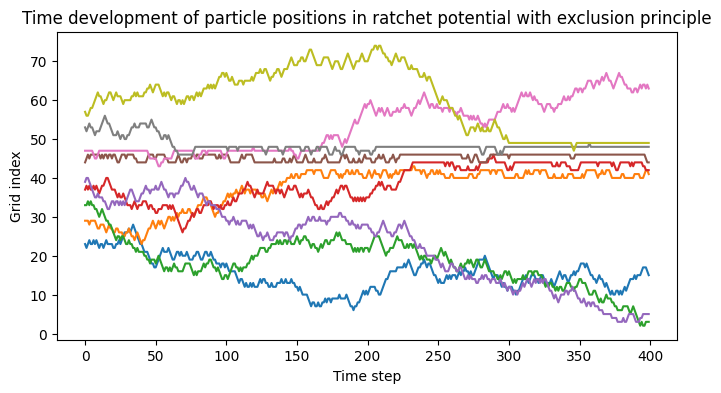

In [35]:
def plot_walk_exclusion_sawtooth(Tp, width, Np = -1, h = 1, T = 5*2*Tp):
    initial_grid = build_initial(b, 2, Nx, Ns, Np)
    grid, cycle_av_J, positions_arr = random_walk_exclusion_sawtooth(initial_grid, Tp, width, h, T)
    
    fig, ax = plt.subplots(figsize = (8, 4))
    
    time = np.arange(len(positions_arr))
    for p in range(positions_arr.shape[1]):
        ax.plot(time, positions_arr[:, p])
    
    ax.set_title("Time development of particle positions in ratchet potential with exclusion principle")
    ax.set_xlabel("Time step")
    ax.set_ylabel("Grid index")    

    plt.show()

    return None

plot_walk_exclusion_sawtooth(Tp, b)

### b.

In [36]:
def plot_current_exclusion_sawtooth(Tp, width, Ns, Nx, Nc, N_min, N_max, h = 1):
    T = Nc*2*Tp
    Np_arr = np.arange(N_min, N_max + 1)
    cycle_avg_J_arr = np.zeros(len(Np_arr))
    rho_arr = np.zeros(len(Np_arr))
    
    for i, Np in enumerate(Np_arr):
        rho = width * Np /(Ns * Nx)
        initial_grid = build_initial(b, 2, Nx, Ns, Np)
        
        grid, cycle_avg_J, positions_arr = random_walk_exclusion_sawtooth(initial_grid, Tp, width, h, T, store_positions = False)
        
        cycle_avg_J_arr[i] = cycle_avg_J.mean()
        rho_arr[i] = rho
        
    fig, ax = plt.subplots(figsize = (8, 4))
    ax.plot(rho_arr, cycle_avg_J_arr)
    ax.set_title("Average current as function of particle density")
    ax.set_xlabel(r"$\rho$")
    ax.set_ylabel(r"$J_{avg}$")

    plt.show()
    
    return

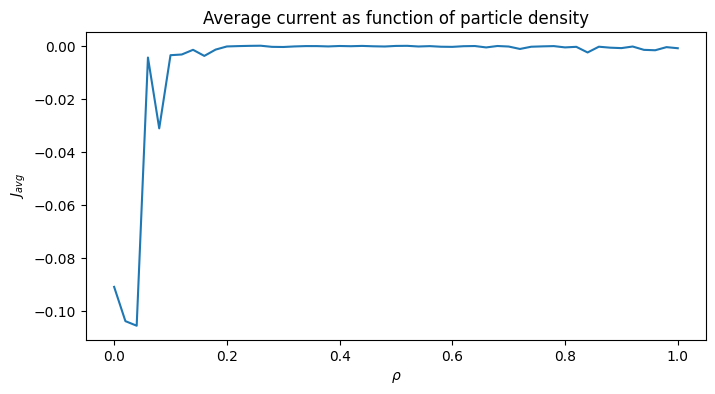

In [37]:
Tp = 300
Ns = 10
b = 20
Nx = 100
alpha = 0.2
Nc = 100

plot_current_exclusion_sawtooth(Tp, b, Ns, Nx, Nc, 0, 50)